# License

Copyright 2019 Navdeep Gill, Patrick Hall, Kim Montgomery, Nick Schmidt

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

**DISCLAIMER**: This notebook is not legal compliance advice.

In [82]:
import h2o
import os
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import shap
import pandas as pd

# init h2o
h2o.init(min_mem_size='30G')
h2o.remove_all()

# set random seed for reproducibility
SEED = 22222

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,3 hours 51 mins
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.9
H2O cluster version age:,1 month and 10 days
H2O cluster name:,H2O_from_python_navdeep_vcnglh
H2O cluster total nodes:,1
H2O cluster free memory:,28.03 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,40
H2O cluster status:,"locked, healthy"


# Helper functions

In [96]:
# Function to get Shapley contribs
def get_shapley(model, train, X):
    # calculate SHAP values using function predict_contributions
    contributions = model.predict_contributions(train[X])
    print("First 5 rows of contributions:\n")
    print(contributions.head(5))
    # convert the H2O Frame to use with shap's visualization functions
    contributions_matrix = contributions.as_data_frame().as_matrix()
    # shap values are calculated for all features
    shap_values = contributions_matrix[:,0:len(X)]
    # expected values is the last returned column
    expected_value = contributions_matrix[:,len(X)-1].min()
    return shap_values, expected_value

In [120]:
def par_dep(xs, frame, model, resolution=20, bins=None):
    
    """ Creates Pandas dataframe containing partial dependence for a single variable.
    
    Args:
        xs: Variable for which to calculate partial dependence.
        frame: Data for which to calculate partial dependence.
        model: Model for which to calculate partial dependence.
        resolution: The number of points across the domain of xs for which to calculate partial dependence.
    
    Returns:
        Pandas dataframe containing partial dependence values.
        
    """
    
    # init empty Pandas frame w/ correct col names
    par_dep_frame = pd.DataFrame(columns=[xs, 'partial_dependence'])
    
    # cache original data 
    col_cache = h2o.deep_copy(frame[xs], xid='col_cache')
  
    # determine values at which to calculate partial dependency
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = (max_ - min_)/resolution
        bins = np.arange(min_, max_, by)
        
    # calculate partial dependency  
    # by setting column of interest to constant 
    for j in bins:
        frame[xs] = j
        par_dep_i = model.predict(frame)
        par_dep_j = par_dep_i.mean()[2]
        par_dep_frame = par_dep_frame.append({xs:j,
                                              'partial_dependence': par_dep_j}, 
                                              ignore_index=True)
        
    # return input frame to original cached state    
    frame[xs] = h2o.get_frame('col_cache')

    return par_dep_frame

In [121]:
def get_quantile_dict(y, id_, frame):

    """ Returns the percentiles of a column y as the indices for another column id_.
    
    Args:
        y: Column in which to find percentiles.
        id_: Id column that stores indices for percentiles of y.
        frame: H2OFrame containing y and id_. 
    
    Returns:
        Dictionary of percentile values and index column values.
    
    """
    
    quantiles_df = frame.as_data_frame()
    quantiles_df.sort_values(y, inplace=True)
    quantiles_df.reset_index(inplace=True)
    
    percentiles_dict = {}
    percentiles_dict[0] = quantiles_df.loc[0, id_]
    percentiles_dict[99] = quantiles_df.loc[quantiles_df.shape[0]-1, id_]
    inc = quantiles_df.shape[0]//10
    
    for i in range(1, 10):
        percentiles_dict[i * 10] = quantiles_df.loc[i * inc,  id_]

    return percentiles_dict

In [83]:
# Load in train and test data used for modelling
train_path = os.sep.join(['..', 'data', 'output', 'hmda_train_processed.csv'])
train = h2o.import_file(train_path)

test_path = os.sep.join(['..', 'data', 'output', 'hmda_test_processed.csv'])
test = h2o.import_file(test_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [84]:
# Inputs and output
X = ['term_360',
'conforming',
'debt_to_income_ratio_missing',
'loan_amount_std',
'loan_to_value_ratio_std',
'no_intro_rate_period_std',
'intro_rate_period_std',
'property_value_std',
'income_std',
'debt_to_income_ratio_std']
fold_column = 'cv_fold'
Y = 'high_priced'

In [85]:
# Load in models
mgbm = h2o.load_model('../models/MGBM_BEST_GRID_v2_HMDA_1575927005.5342216/mgbm_grid2_model_28') 
gbm = h2o.load_model('../models/GBM_BEST_GRID_v2_HMDA_1575927435.3138359/gbm_grid2_model_20')
mxgb = h2o.load_model('../models/MXGB_BEST_GRID_v2_HMDA_1575928031.3747108/mxgb_grid2_model_12')
xgb = h2o.load_model('../models/XGB_BEST_GRID_v2_HMDA_1575928848.548365/xgb_grid2_model_11')

In [86]:
# Check performance across all models on test set
print(f"Test AUC for Constrained H2O GBM: {mgbm.model_performance(test).auc()}")
print(f"Test AUC for Unconstrained H2O GBM: {gbm.model_performance(test).auc()}\n")
print(f"Test AUC for Constrained H2O XGBoost: {mxgb.model_performance(test).auc()}")
print(f"Test AUC for Unconstrained H2O XGBoost: {xgb.model_performance(test).auc()}\n")

print(f"Test Logloss for Constrained H2O GBM: {mgbm.model_performance(test).logloss()}")
print(f"Test Logloss for Unconstrained H2O GBM: {gbm.model_performance(test).logloss()}\n")
print(f"Test Logloss for Constrained H2O XGBoost: {mxgb.model_performance(test).logloss()}")
print(f"Test Logloss for Unconstrained H2O XGBoost: {xgb.model_performance(test).logloss()}\n")

print(f"Test Accuracy for Constrained H2O GBM: {mgbm.model_performance(test).accuracy()}")
print(f"Test Accuracy for Unconstrained H2O GBM: {gbm.model_performance(test).accuracy()}\n")
print(f"Test Accuracy for Constrained H2O XGBoost: {mxgb.model_performance(test).accuracy()}")
print(f"Test Accuracy for Unconstrained H2O XGBoost: {xgb.model_performance(test).accuracy()}\n")

print(f"Test RMSE for Constrained H2O GBM: {mgbm.model_performance(test).rmse()}")
print(f"Test RMSE for Unconstrained H2O GBM: {gbm.model_performance(test).rmse()}\n")
print(f"Test RMSE for Constrained H2O XGBoost: {mxgb.model_performance(test).rmse()}")
print(f"Test RMSE for Unconstrained H2O XGBoost: {xgb.model_performance(test).rmse()}\n")

Test AUC for Constrained H2O GBM: 0.8139763217062082
Test AUC for Unconstrained H2O GBM: 0.8277469182063814

Test AUC for Constrained H2O XGBoost: 0.8076432704169134
Test AUC for Unconstrained H2O XGBoost: 0.8295507199389082

Test Logloss for Constrained H2O GBM: 0.2587426002772106
Test Logloss for Unconstrained H2O GBM: 0.25208476941092833

Test Logloss for Constrained H2O XGBoost: 0.2611140704563793
Test Logloss for Unconstrained H2O XGBoost: 0.25100479873302917

Test Accuracy for Constrained H2O GBM: [[0.669132813459497, 0.9026776259391861]]
Test Accuracy for Unconstrained H2O GBM: [[0.582636709903675, 0.9032070999949574]]

Test Accuracy for Constrained H2O XGBoost: [[0.5486110210418701, 0.9026524128889113]]
Test Accuracy for Unconstrained H2O XGBoost: [[0.5549438446760178, 0.9032323130452322]]

Test RMSE for Constrained H2O GBM: 0.2784104474952574
Test RMSE for Unconstrained H2O GBM: 0.27587498910179936

Test RMSE for Constrained H2O XGBoost: 0.27956390287701544
Test RMSE for Uncon

In [87]:
# Get predictions
mgbm_preds = mgbm.predict(test)
print("Constrained H2O GBM Preds")
print(mgbm_preds.head())

gbm_preds = gbm.predict(test)
print("Unconstrained H2O GBM Preds")
print(gbm_preds.head())

mxgb_preds = mxgb.predict(test)
print("Constrained H2O XGBoost Preds")
print(mxgb_preds.head())

xgb_preds = xgb.predict(test)
print("Unconstrained H2O XGBoost Preds")
print(xgb_preds.head())

gbm prediction progress: |████████████████████████████████████████████████| 100%
Constrained H2O GBM Preds


predict,p0,p1
0,0.917069,0.0829313
0,0.976429,0.0235707
1,0.817959,0.182041
0,0.986566,0.013434
0,0.930334,0.0696665
0,0.871302,0.128698
1,0.651654,0.348346
0,0.966014,0.0339858
0,0.995952,0.00404805
0,0.988198,0.0118022



gbm prediction progress: |████████████████████████████████████████████████| 100%
Unconstrained H2O GBM Preds


predict,p0,p1
0,0.913611,0.0863887
0,0.982902,0.0170984
1,0.796234,0.203766
0,0.991732,0.0082676
0,0.925204,0.0747962
0,0.840924,0.159076
1,0.660699,0.339301
0,0.974465,0.0255352
0,0.994103,0.00589731
0,0.993241,0.00675903



xgboost prediction progress: |████████████████████████████████████████████| 100%
Constrained H2O XGBoost Preds


predict,p0,p1
0,0.919392,0.0806079
0,0.974399,0.025601
1,0.809237,0.190763
0,0.986474,0.0135261
0,0.913625,0.0863754
1,0.83844,0.16156
1,0.684803,0.315197
0,0.944054,0.0559459
0,0.993698,0.00630215
0,0.988124,0.0118755



xgboost prediction progress: |████████████████████████████████████████████| 100%
Unconstrained H2O XGBoost Preds


predict,p0,p1
0,0.909295,0.0907051
0,0.991741,0.0082592
1,0.794388,0.205612
0,0.992928,0.00707158
0,0.906304,0.0936961
0,0.854463,0.145537
1,0.629761,0.370239
0,0.956385,0.0436145
0,0.995305,0.00469477
0,0.994993,0.00500709


In [88]:
# Merged predictions from each model onto test set
model_dict = {'mgbm' : mgbm_preds, 'gbm' : gbm_preds, 'mxgb' : mxgb_preds, 'xgb' : xgb_preds}

In [89]:
for model_name, model_preds in model_dict.items():
    yhat = 'high_priced_' + model_name + '_pred'
    test = test.cbind(model_preds['p1'])
    test.set_name('p1', yhat)

In [94]:
# Add an ID column to test
test['Id'] = h2o.H2OFrame(np.arange(len(test)))

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [95]:
test.head()

Unnamed: 0,high_priced,term_360,conforming,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,agegte62,agelt62,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced_mgbm_pred,high_priced_gbm_pred,high_priced_mxgb_pred,high_priced_xgb_pred,Id
131497,0,1,1,0,1,0,0,0,1,0,1,0,nan,nan,False,-0.470421,0.345133,0.244394,-0.215304,-0.505098,-0.0080847,-2.52755,0.0829313,0.0863887,0.0806079,0.0907051,0
851117,0,1,1,0,1,0,0,0,0,1,1,0,nan,nan,False,0.321082,0.342439,-4.09175,3.20323,0.0807632,-0.0108565,-1.15641,0.0235707,0.0170984,0.025601,0.0082592,1
835616,0,1,1,0,0,1,0,0,0,1,nan,nan,0,1,False,-0.118642,0.55252,0.244394,-0.215304,-0.289254,-0.0160538,1.03742,0.182041,0.203766,0.190763,0.205612,2
121491,0,0,1,0,0,1,0,0,0,1,1,0,1,0,False,-0.64631,-1.19197,0.244394,-0.215304,-0.320089,-0.02922,0.0319161,0.013434,0.0082676,0.0135261,0.00707158,3
4.47964e+06,0,1,1,0,0,1,0,0,0,1,nan,nan,0,1,False,0.277109,0.336837,0.244394,-0.215304,0.0499284,0.00057731,0.763191,0.0696665,0.0747962,0.0863754,0.0936961,4
843194,1,1,1,0,1,0,0,0,nan,nan,nan,nan,0,1,False,0.321082,0.444679,0.244394,-0.215304,0.0499284,-0.0351102,3.87111,0.128698,0.159076,0.16156,0.145537,5
6.37726e+06,0,1,1,0,0,1,0,0,0,1,0,1,nan,nan,False,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.0340707,1.58588,0.348346,0.339301,0.315197,0.370239,6
5.25537e+06,0,1,1,0,0,1,0,0,1,0,0,1,nan,nan,False,-0.690283,-0.182763,0.244394,-0.215304,-0.597602,-0.0247158,0.94601,0.0339858,0.0255352,0.0559459,0.0436145,7
4.59782e+06,0,1,1,0,1,0,0,0,0,1,1,0,nan,nan,False,0.716833,-0.682306,-4.09175,4.61086,0.913302,-0.0243693,0.306144,0.00404805,0.00589731,0.00630215,0.00469477,8
6.13819e+06,0,1,1,0,0,1,0,0,0,1,nan,nan,1,0,False,0.145192,-0.246306,0.244394,-0.215304,0.142433,-0.0302594,1.03742,0.0118022,0.00675903,0.0118755,0.00500709,9


# Shapley for MGBM on train set

In [14]:
shap_values_mgbm_train, expected_value_mgbm_train = get_shapley(mgbm, train, X)

First 5 rows of contributions:



term_360,conforming,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,BiasTerm
-0.00018562,0.00525494,-0.00119815,0.107912,0.887901,-0.00580012,-0.00468927,0.527515,0.0166724,0.272783,-2.91142
-0.000157597,0.00815592,-0.0021666,-0.146934,0.536647,-0.0180488,-0.00987545,-0.0619093,-0.00628095,-0.29549,-2.91142
-0.00274492,0.00705713,-0.00344599,0.388739,0.620492,-0.14514,-0.943326,0.0448351,-0.0277831,0.018798,-2.91142
-0.000380784,0.012291,-0.00452263,-0.0809743,-1.31932,-0.0377705,-0.0840968,-0.308984,-0.000403701,-0.190623,-2.91142
-0.000354039,0.00488184,-0.00119556,0.354748,1.07438,-0.00380643,-0.00236983,0.153142,0.0352928,0.256853,-2.91142


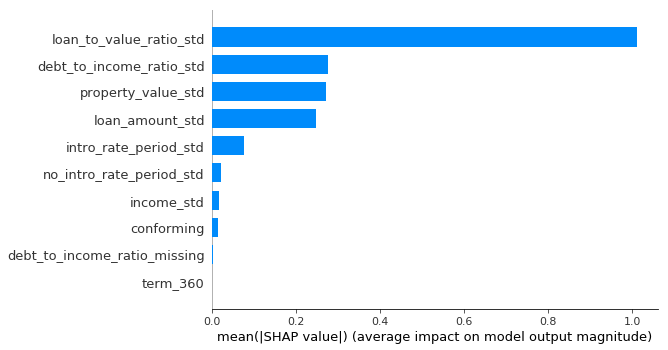

In [16]:
shap.summary_plot(shap_values_mgbm_train, X, plot_type="bar")

# PDP/ICE for Top 3 Variables from MGBM Global Shapley

## Loan To Value Ratio

In [122]:
par_dep_ltvr_mgbm = par_dep('loan_to_value_ratio_std', test[X], mgbm)

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

    loan_to_value_ratio_std  partial_dependence
0                 -3.458657            0.009683
1                 -1.397833            0.016919
2                  0.662992            0.165341
3                  2.723816            0.390009
4                  4.784640            0.403800
5                  6.845465            0.403800
6                  8.906289            0.403800
7                 10.967113            0.403800
8                 13.027937            0.403800
9                 15.088762            0.403800
10                17.149586            0.403800
11                19.210410            0.403800
12                21.271234            0.403800
13                23.332059            0.403800
14                25.392883            0.403800
15                27.453707            0.403800
16                29.514531            0.403800
17                31.575356            0.403800
18                33.636180            0.403800
19                35.697004            0

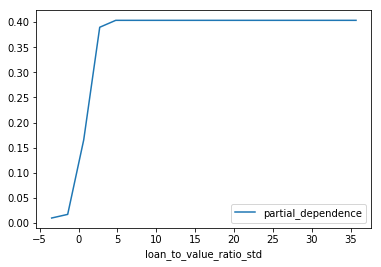

In [123]:
par_dep_ltvr_mgbm.plot.line(x='loan_to_value_ratio_std', y='partial_dependence')
print(par_dep_ltvr_mgbm)

In [125]:
quantile_dict_mgbm = get_quantile_dict('high_priced_mgbm_pred', 'Id', test)
bins = list(par_dep_ltvr_mgbm['loan_to_value_ratio_std'])
for i in sorted(quantile_dict_mgbm.keys()):
    col_name = 'Percentile_' + str(i)
    par_dep_ltvr_mgbm[col_name] = par_dep('loan_to_value_ratio_std', 
                                            test[test['Id'] == int(quantile_dict_mgbm[i])][X], 
                                            mgbm, 
                                            bins=bins)['partial_dependence']
par_dep_ltvr_mgbm

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

,loan_to_value_ratio_std,partial_dependence,Percentile_0,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_99
0,-3.458657,0.009683,0.001137,0.003749,0.006537,0.004340,0.003281,0.015155,0.007268,0.008477,0.008990,0.009316,0.630914
1,-1.397833,0.016919,0.010690,0.005034,0.009514,0.006013,0.004820,0.045743,0.010340,0.012469,0.012938,0.027256,0.879914
2,0.662992,0.165341,0.163382,0.023154,0.283690,0.093499,0.061562,0.352883,0.092074,0.144706,0.189882,0.242167,0.995922
3,2.723816,0.390009,0.223499,0.034190,0.519882,0.373557,0.204028,0.670517,0.436243,0.308917,0.481739,0.618377,0.998900
4,4.784640,0.403800,0.223499,0.034190,0.549098,0.401426,0.223766,0.670517,0.465315,0.334538,0.511094,0.618377,0.998900
5,6.845465,0.403800,0.223499,0.034190,0.549098,0.401426,0.223766,0.670517,0.465315,0.334538,0.511094,0.618377,0.998900
6,8.906289,0.403800,0.223499,0.034190,0.549098,0.401426,0.223766,0.670517,0.465315,0.334538,0.511094,0.618377,0.998900
7,10.967113,0.403800,0.223499,0.034190,0.549098,0.401426,0.223766,0.670517,0.465315,0.334538,0.511094,0.618377,0.998900
8,13.027937,0.403800,0.223499,0.034190,0.549098,0.401426,0.223766,0.670517,0.465315,0.334538,0.511094,0.618377,0.998900
9,15.088762,0.403800,0.223499,0.034190,0.549098,0.401426,0.223766,0.670517,0.465315,0.334538,0.511094,0.618377,0.998900


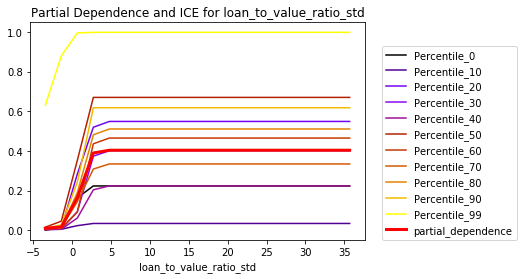

In [127]:
fig, ax = plt.subplots()
par_dep_ltvr_mgbm.drop('partial_dependence', axis=1).plot(x='loan_to_value_ratio_std', colormap='gnuplot', ax=ax)

par_dep_ltvr_mgbm.plot(title='Partial Dependence and ICE for loan_to_value_ratio_std',
                         x='loan_to_value_ratio_std', 
                         y='partial_dependence',
                         style='r-', 
                         linewidth=3, 
                         ax=ax)

_ = plt.legend(bbox_to_anchor=(1.05, 0),
               loc=3, 
               borderaxespad=0.)

## Debt To Income Ratio

In [130]:
par_dep_dtir_mgbm = par_dep('debt_to_income_ratio_std', test[X], mgbm)

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

    debt_to_income_ratio_std  partial_dependence
0                  -2.527547            0.048359
1                  -2.207614            0.048359
2                  -1.887681            0.048359
3                  -1.567748            0.055157
4                  -1.247815            0.055157
5                  -0.927882            0.055157
6                  -0.607950            0.070371
7                  -0.288017            0.072873
8                   0.031916            0.086300
9                   0.351849            0.102594
10                  0.671782            0.114327
11                  0.991715            0.118089
12                  1.311648            0.147673
13                  1.631580            0.161627
14                  1.951513            0.161627
15                  2.271446            0.161627
16                  2.591379            0.161995
17                  2.911312            0.167971
18                  3.231245            0.167971
19                  

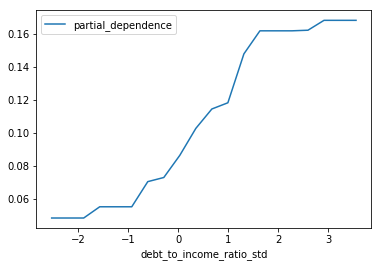

In [131]:
par_dep_dtir_mgbm.plot.line(x='debt_to_income_ratio_std', y='partial_dependence')
print(par_dep_dtir_mgbm)

In [132]:
quantile_dict_mgbm = get_quantile_dict('high_priced_mgbm_pred', 'Id', test)
bins = list(par_dep_dtir_mgbm['debt_to_income_ratio_std'])
for i in sorted(quantile_dict_mgbm.keys()):
    col_name = 'Percentile_' + str(i)
    par_dep_dtir_mgbm[col_name] = par_dep('debt_to_income_ratio_std', 
                                            test[test['Id'] == int(quantile_dict_mgbm[i])][X], 
                                            mgbm, 
                                            bins=bins)['partial_dependence']
par_dep_dtir_mgbm

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

,debt_to_income_ratio_std,partial_dependence,Percentile_0,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_99
0,-2.527547,0.048359,0.001006,0.007161,0.006805,0.010442,0.022788,0.038381,0.049462,0.073574,0.062842,0.121934,0.115587
1,-2.207614,0.048359,0.001006,0.007161,0.006805,0.010442,0.022788,0.038381,0.049462,0.073574,0.062842,0.121934,0.115587
2,-1.887681,0.048359,0.001006,0.007161,0.006805,0.010442,0.022788,0.038381,0.049462,0.073574,0.062842,0.121934,0.115587
3,-1.567748,0.055157,0.001137,0.007161,0.006821,0.010501,0.022916,0.044473,0.050596,0.082178,0.066262,0.156710,0.142169
4,-1.247815,0.055157,0.001137,0.007161,0.006821,0.010501,0.022916,0.044473,0.050596,0.082178,0.066262,0.156710,0.142169
5,-0.927882,0.055157,0.001137,0.007161,0.006821,0.010501,0.022916,0.044473,0.050596,0.082178,0.066262,0.156710,0.142169
6,-0.607950,0.070371,0.001377,0.008062,0.007860,0.011764,0.025759,0.051762,0.058140,0.113064,0.095798,0.195475,0.168896
7,-0.288017,0.072873,0.001462,0.008536,0.008281,0.012422,0.027354,0.052082,0.062325,0.118406,0.100416,0.197993,0.176707
8,0.031916,0.086300,0.001677,0.009265,0.009068,0.013781,0.031971,0.054585,0.080362,0.146349,0.141139,0.207435,0.347034
9,0.351849,0.102594,0.002081,0.009466,0.009202,0.014828,0.034126,0.057307,0.084327,0.191044,0.170158,0.256114,0.418690


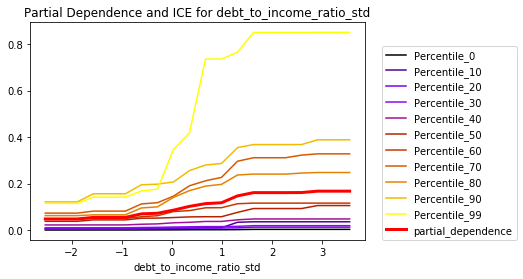

In [133]:
fig, ax = plt.subplots()
par_dep_dtir_mgbm.drop('partial_dependence', axis=1).plot(x='debt_to_income_ratio_std', colormap='gnuplot', ax=ax)

par_dep_dtir_mgbm.plot(title='Partial Dependence and ICE for debt_to_income_ratio_std',
                         x='debt_to_income_ratio_std', 
                         y='partial_dependence',
                         style='r-', 
                         linewidth=3, 
                         ax=ax)

_ = plt.legend(bbox_to_anchor=(1.05, 0),
               loc=3, 
               borderaxespad=0.)

# Property Value

In [134]:
par_dep_pv_mgbm = par_dep('property_value_std', test[X], mgbm)

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

    property_value_std  partial_dependence
0            -1.029289            0.062623
1             0.392194            0.098002
2             1.813678            0.115490
3             3.235161            0.117096
4             4.656644            0.143202
5             6.078127            0.144196
6             7.499610            0.144449
7             8.921094            0.145380
8            10.342577            0.144763
9            11.764060            0.144201
10           13.185543            0.144201
11           14.607026            0.144211
12           16.028510            0.144211
13           17.449993            0.144211
14           18.871476            0.143405
15           20.292959            0.143405
16           21.714442            0.143405
17           23.135925            0.143405
18           24.557409            0.143405
19           25.978892            0.143405


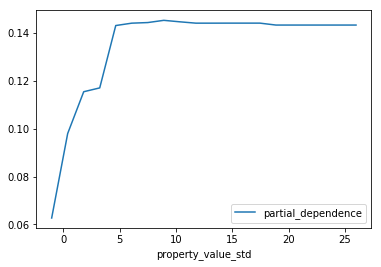

In [135]:
par_dep_pv_mgbm.plot.line(x='property_value_std', y='partial_dependence')
print(par_dep_pv_mgbm)

In [136]:
quantile_dict_mgbm = get_quantile_dict('high_priced_mgbm_pred', 'Id', test)
bins = list(par_dep_pv_mgbm['property_value_std'])
for i in sorted(quantile_dict_mgbm.keys()):
    col_name = 'Percentile_' + str(i)
    par_dep_pv_mgbm[col_name] = par_dep('property_value_std', 
                                            test[test['Id'] == int(quantile_dict_mgbm[i])][X], 
                                            mgbm, 
                                            bins=bins)['partial_dependence']
par_dep_pv_mgbm

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

,property_value_std,partial_dependence,Percentile_0,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_99
0,-1.029289,0.062623,0.017922,0.003288,0.011873,0.028231,0.043633,0.046260,0.067587,0.059682,0.069442,0.171951,0.144222
1,0.392194,0.098002,0.001147,0.006754,0.009153,0.014087,0.024788,0.010790,0.115484,0.115203,0.195568,0.211378,0.719185
2,1.813678,0.115490,0.001768,0.009282,0.009335,0.013651,0.026047,0.029433,0.137219,0.117765,0.215101,0.256528,0.759368
3,3.235161,0.117096,0.001753,0.007338,0.009523,0.015097,0.027440,0.029664,0.142681,0.117315,0.219318,0.256528,0.761627
4,4.656644,0.143202,0.001658,0.008024,0.009008,0.015081,0.033986,0.027548,0.214901,0.142426,0.326819,0.271166,0.751307
5,6.078127,0.144196,0.001658,0.008472,0.009008,0.015082,0.033988,0.027550,0.214901,0.142434,0.326819,0.271166,0.751307
6,7.499610,0.144449,0.001658,0.021394,0.009008,0.015082,0.033988,0.027550,0.214901,0.142434,0.326819,0.271166,0.751307
7,8.921094,0.145380,0.001658,0.042710,0.009008,0.015082,0.033988,0.027550,0.214901,0.142434,0.326819,0.271166,0.751307
8,10.342577,0.144763,0.001613,0.033366,0.008166,0.014058,0.033988,0.027557,0.214901,0.142434,0.326819,0.271166,0.746155
9,11.764060,0.144201,0.001613,0.031958,0.008168,0.014058,0.033988,0.027557,0.214901,0.142434,0.326819,0.271166,0.746206


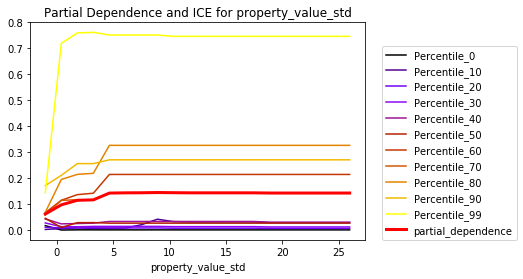

In [137]:
fig, ax = plt.subplots()
par_dep_pv_mgbm.drop('partial_dependence', axis=1).plot(x='property_value_std', colormap='gnuplot', ax=ax)

par_dep_pv_mgbm.plot(title='Partial Dependence and ICE for property_value_std',
                         x='property_value_std', 
                         y='partial_dependence',
                         style='r-', 
                         linewidth=3, 
                         ax=ax)

_ = plt.legend(bbox_to_anchor=(1.05, 0),
               loc=3, 
               borderaxespad=0.)